In [2]:
import os
import sys

def add_to_sys_path(relative_path):
    abs_path = os.path.abspath(os.path.join(os.getcwd(), relative_path))
    if abs_path not in sys.path:
        sys.path.append(abs_path)

add_to_sys_path(os.path.join('..', '..', '..', 'Utils'))
add_to_sys_path(os.path.join('..', '..', '..', 'Model'))
add_to_sys_path(os.path.join('..', '..', '..', 'alg'))

In [3]:
import pandas as pd
import numpy as np
import random
import shap

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

from algorithm import *
from explainer import *
from genetic import *
import dalex as dx
from XGB import base_model as base_model_call
from model_data_processing import Data_Handler, Model_Metrics_Visualizer

In [4]:
data = pd.read_csv('../../../Dataset/cybersecurity_intrusion_data.csv')
# data = data.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'uid', 'originh', 'responh'])
has_failed_logins = []
for i in data['failed_logins']:
    if i:
        has_failed_logins.append(1)
    else:
        has_failed_logins.append(0)

data['has_failed_logins'] = has_failed_logins
data['protocol_type'] = data['protocol_type'].replace({'ICMP': 0, 'TCP': 1, 'UDP': 2})
data['encryption_used'] = data['encryption_used'].replace({'AES': 0, 'DES': 1})
data['attack_detected'] = data['attack_detected'].replace({0: 1, 1: 0})
data.head()

/tmp/ipykernel_423535/1412528349.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['protocol_type'] = data['protocol_type'].replace({'ICMP': 0, 'TCP': 1, 'UDP': 2})
/tmp/ipykernel_423535/1412528349.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['encryption_used'] = data['encryption_used'].replace({'AES': 0, 'DES': 1})


,session_id,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,browser_type,unusual_time_access,attack_detected,has_failed_logins
0,SID_00001,599,1,4,492.983263,1.0,0.606818,1,Edge,0,0,1
1,SID_00002,472,1,3,1557.996461,1.0,0.301569,0,Firefox,0,1,0
2,SID_00003,629,1,3,75.044262,1.0,0.739164,2,Chrome,0,0,1
3,SID_00004,804,2,4,601.248835,1.0,0.123267,0,Unknown,0,0,0
4,SID_00005,453,1,5,532.540888,0.0,0.054874,1,Firefox,0,1,1


In [5]:
data = data.drop(data.select_dtypes(include='object').columns, axis=1)
data.head()

,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,attack_detected,has_failed_logins
0,599,1,4,492.983263,1.0,0.606818,1,0,0,1
1,472,1,3,1557.996461,1.0,0.301569,0,0,1,0
2,629,1,3,75.044262,1.0,0.739164,2,0,0,1
3,804,2,4,601.248835,1.0,0.123267,0,0,0,0
4,453,1,5,532.540888,0.0,0.054874,1,0,1,1


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9537 entries, 0 to 9536
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   network_packet_size  9537 non-null   int64  
 1   protocol_type        9537 non-null   int64  
 2   login_attempts       9537 non-null   int64  
 3   session_duration     9537 non-null   float64
 4   encryption_used      7571 non-null   float64
 5   ip_reputation_score  9537 non-null   float64
 6   failed_logins        9537 non-null   int64  
 7   unusual_time_access  9537 non-null   int64  
 8   attack_detected      9537 non-null   int64  
 9   has_failed_logins    9537 non-null   int64  
dtypes: float64(3), int64(7)
memory usage: 745.2 KB


In [7]:
protected_feature = 'has_failed_logins'

In [ ]:
x_train, x_test, y_train, y_test, feature_names, scaler = Data_Handler(
        df=data,
        target_column='attack_detected',
        protected_feature=protected_feature,
        do_scaling=True,
        scale_all_features=True,
        correlation_threshold=0.35,
        test_size=0.3,
        random_state=0
    )


Applying feature correlation removal...
Scaling numerical features: ['network_packet_size', 'login_attempts', 'session_duration', 'ip_reputation_score', 'failed_logins']


In [10]:
print(len(x_train.columns))
x_train.head()

9


,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,has_failed_logins
4521,1.070864,1,1.484552,-0.300794,1.0,-0.038904,0.461359,0,1
8445,-0.860225,1,2.492526,-0.940790,NaN,-1.298406,0.461359,0,1
9438,0.825089,2,1.988539,-0.342331,1.0,-1.479774,0.461359,0,1
2357,0.137923,1,0.476579,0.587420,0.0,0.025405,-0.507364,0,1
5798,0.509093,1,-0.531395,-0.324137,1.0,-0.488635,-0.507364,0,1


In [11]:
feature_names

['network_packet_size',
 'protocol_type',
 'login_attempts',
 'session_duration',
 'encryption_used',
 'ip_reputation_score',
 'failed_logins',
 'unusual_time_access',
 'has_failed_logins']

In [12]:
# Assuming X_train, X_test, y_train, y_test are already separated
# And df is the original DataFrame with its original column names (e.g., 'thalach', 'trestbps', 'chol')

# Define VARIABLES_TO_CHANGE using the original column names
VARIABLES_TO_CHANGE = ['network_packet_size',
 'protocol_type',
 'login_attempts',
 'session_duration',
 'encryption_used',
 'ip_reputation_score',
 'failed_logins',
 'unusual_time_access']

# Define the full list of columns you want to select for your features
selected_columns = [protected_feature] + VARIABLES_TO_CHANGE

# Apply the column selection to X_train and X_test
x_train = x_train.loc[:, selected_columns]
x_test = x_test.loc[:, selected_columns]

# y_train and y_test remain unchanged as they already contain the target variable

Accuracy: 0.8693221523410203
Precision: 0.8941459481716347
Recall: 0.8693221523410203
F-1: 0.865254735903147


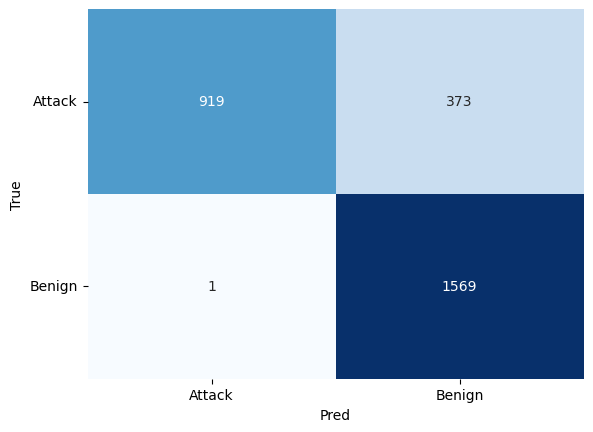

In [13]:
model = base_model_call(x_train, y_train, protected_feature, True)
y_pred = model.predict(x_test)
Model_Metrics_Visualizer(y_test, y_pred)

In [14]:
explainer = Explainer(model, x_test, 't')

In [15]:
e = dx.Explainer(model, x_test, y_test, verbose=False)
e.model_performance()

,recall,precision,f1,accuracy,auc
XGBClassifier,0.999363,0.80793,0.893508,0.869322,0.876242


In [16]:
pd.DataFrame({'variable': x_train.columns, 'importance_split': model.feature_importances_,
              'importance_shap': explainer.shap_values(explainer.data),
              'importance_perm': e.model_parts(B=25).result.sort_values("variable").iloc[2::,:].dropout_loss})


,variable,importance_split,importance_shap,importance_perm
3,has_failed_logins,0.028965,0.002617,0.121743
9,network_packet_size,0.008969,0.003692,0.296910
4,protocol_type,0.008029,0.000915,0.122498
7,login_attempts,0.249559,0.103218,0.197303
8,session_duration,0.011198,0.011174,0.264373
5,encryption_used,0.006931,0.003123,0.122758
2,ip_reputation_score,0.161936,0.090879,0.121508
6,failed_logins,0.491319,0.170235,0.126707
0,unusual_time_access,0.033096,0.003384,0.121081


In [17]:
I = 7
for i in range(len(y_test)):
    if y_test[i]==1:
        I=i
        break
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I)
e.data.iloc[[I]].assign(y=e.y[[I]], y_hat=e.y_hat[[I]])

,has_failed_logins,network_packet_size,protocol_type,login_attempts,session_duration,encryption_used,ip_reputation_score,failed_logins,unusual_time_access,y,y_hat
1536,1,0.509093,1,-0.027408,1.275727,0.0,0.510663,1.430082,0,0,0.010572


In [18]:
a = GeneticAlgorithm(explainer, constant=[protected_feature], row_id=I, alpha=0.75, pop_count=100)
t = a.explainer.shap_values(a._X, a._x)
t = np.array([i + (t[0] / (len(t) - 3)) if i > 0 else i - (t[0] / (len(t) - 3)) for i in t])
t[0] = -0.005
pd.DataFrame({'variable': a.explainer.data.columns, 'shap_values': a.explainer.shap_values(a._X, a._x), 'target': t})

,variable,shap_values,target
0,has_failed_logins,-0.001258,-0.005000
1,network_packet_size,0.001591,0.001381
2,protocol_type,0.000235,0.000025
3,login_attempts,-0.003057,-0.002847
4,session_duration,-0.003630,-0.003421
5,encryption_used,0.001037,0.000828
6,ip_reputation_score,0.003692,0.003482
7,failed_logins,-0.496866,-0.496656
8,unusual_time_access,0.000605,0.000395


In [19]:
a.fool_aim(target=t, max_iter=200, random_state=0)

Iter: 500 || Loss: -0.4120645295509334: 100%|██████████| 500/500 [14:49<00:00,  1.78s/it] 


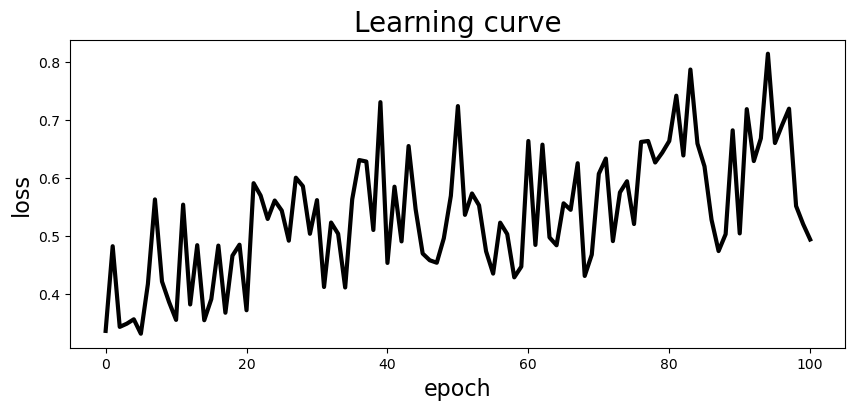

In [18]:
a.plot_losses()

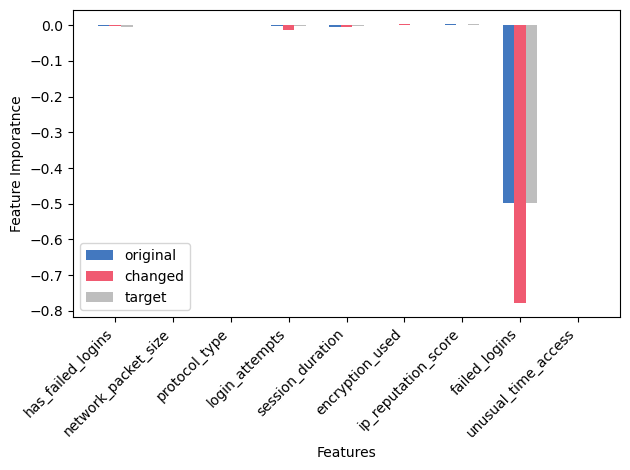

In [20]:
a.plot_explanation()

/home/jn/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/jn/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jn/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jn/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When

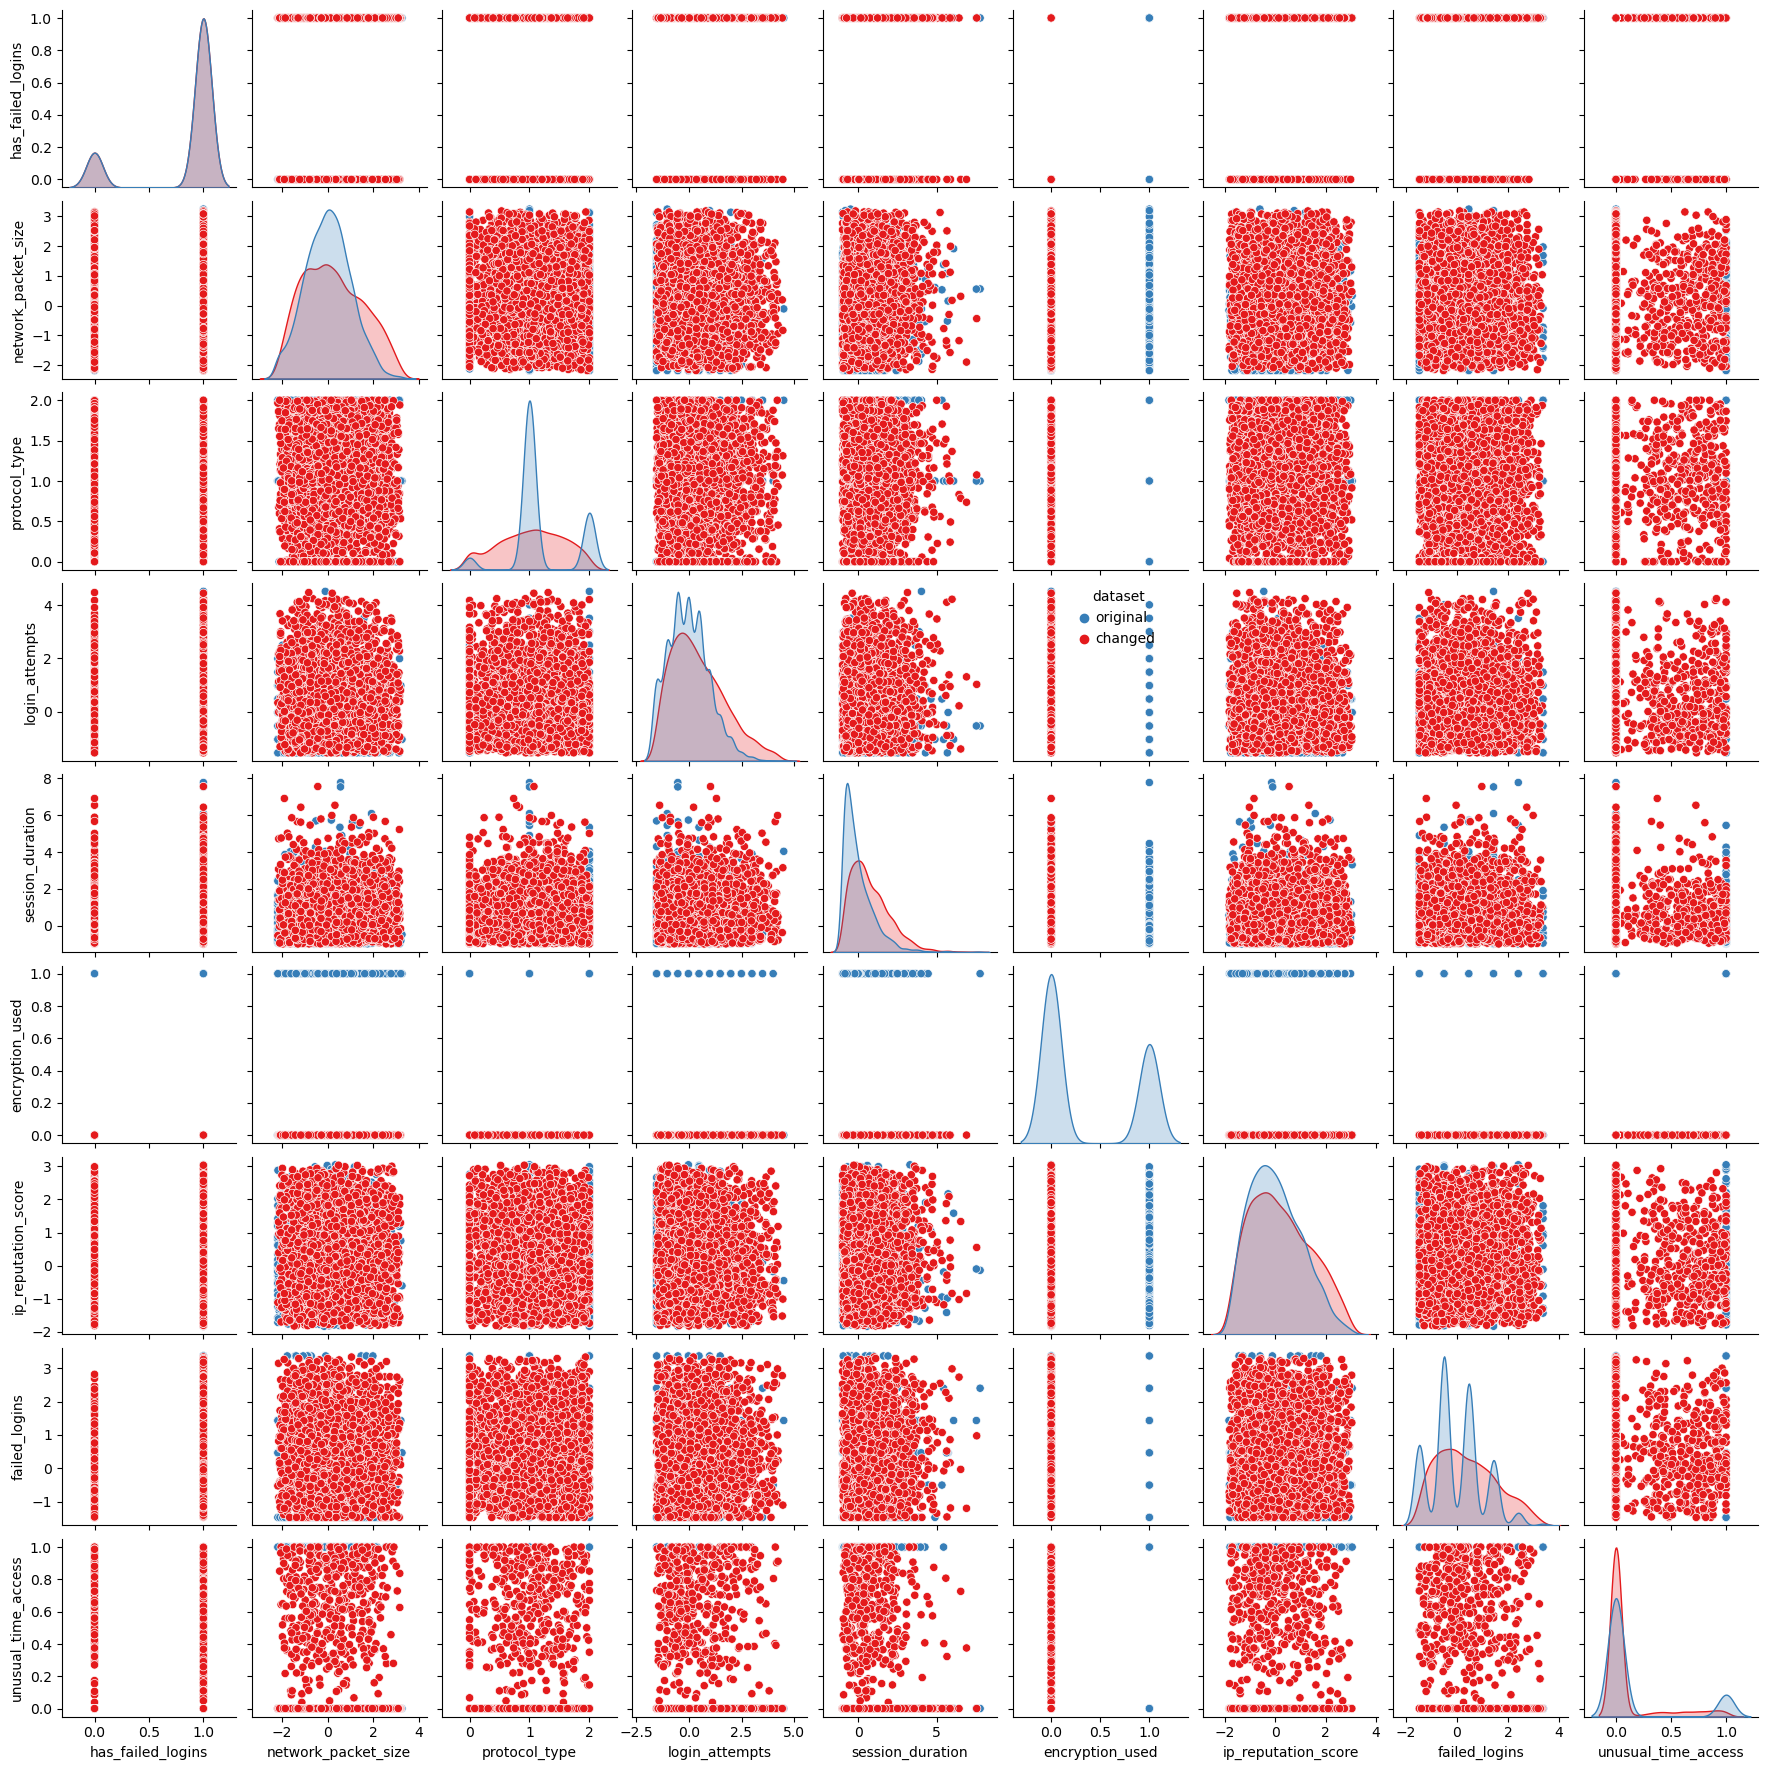

In [21]:
a.plot_data()

In [ ]:
a.display_feature_rank_changes()